In [26]:
import numpy as np
from QfromPackage.Qfrom_slim import Qfrom as Qfrom_slim
from QfromPackage.Qfrom_slim import agg
from QfromPackage.Qfrom_slim import func
from QfromPackage.Qfrom_slim import out
from QfromPackage.Qfrom_slim import col
from QfromPackage.Qfrom_slim import plot
import time
from collections.abc import Iterable
import pandas as pd

In [27]:
def iter_array_list(array_list: list[np.ndarray]) -> Iterable|None:
    if len(array_list) == 0:
        return None
    if len(array_list) == 1:
        return iter(array_list[0])
    else:
        return zip(*array_list)
def iter_table_dict(table_dict: dict[str, np.ndarray]) -> Iterable|None:
    return iter_array_list(list(table_dict.values()))
def first(iterable, predicate_func=None):
    if predicate_func:
        for item in iterable:
            if predicate_func(item):
                return item
        return None
    return next(iter(iterable))
def array_tuple_to_tuple_array(array_list):
        l = list(zip(*array_list))
        #it = np.nditer(array_list, flags=['refs_ok'])
        a = np.empty(len(array_list[0]), dtype=object)
        a[:] = l
        return a

In [28]:
def get_p(n):
    return [1/(2**(i+1)) if i+1 != n else 1/(2**(i)) for i in range(n)]

In [29]:
def get_tab_data(n):
    name_list = ['Ann', 'Steven', 'Max', 'Jack', 'Julia', 'Clara', 'Emma', 'Bob', 'Anna' 'Lena']
    job_list = ['manager', 'freelancer', 'employee', 'artist', 'jobless', 'technician', 'boss', 'polician']
    max_age = 100
    
    name_ran_array = np.random.choice(name_list, n, p=get_p(len(name_list)))
    age_ran_list = np.random.randint(max_age, size=n)
    job_ran_array = np.random.choice(job_list, n, p=get_p(len(job_list)))

    return {
        'name': name_ran_array,
        'age': age_ran_list,
        'job': job_ran_array,
        }

def get_num_data(n):
    max_value = 1000
    return {
        'x': np.random.randint(max_value, size=n)
    }

In [30]:
def run_test(test):
    result_data = Qfrom_slim()

    test_name = test['test_name']
    data_gen_func = test['data_source_func']
    data_size_list = test['data_size_list']
    item_name_list = test['item_name_list']
    item_setup_list = test['item_setup_list']
    item_func_list = test['item_func_list']

    data_sets = [data_gen_func(size) for size in data_size_list]

    for item_name, setup, func in zip(item_name_list, item_setup_list, item_func_list):
        for data_set, data_size in zip(data_sets, data_size_list):
            #start_time = time.time()
            data = setup(data_set)
            #delta_time = time.time() - start_time
            #print(f'{item_name} {delta_time=}')

            start_time = time.time()
            result = func(data)
            delta_time = time.time() - start_time
            
            if isinstance(result, Iterable):
                result = len(result)
            result_data.append({
                'test_name': test_name,
                'item_name': item_name,
                'data_size': data_size,
                'delta_time': delta_time,
                'result': result,
                })

    return result_data

In [31]:
class np_ext():
    @classmethod
    def col_stack(cls, cols):
        col_types = ','.join([str(c.dtype) for c in cols])
        a = np.empty(len(cols[0]), dtype=col_types)

        for i in np.ndindex(len(a)):
            a[i] = tuple(c[i] for c in cols)

        return a
    @classmethod
    def col_add(cls, array, col):
        col_types = [array.dtype[n] for n in array.dtype.names] + [col.dtype]
        col_types = ','.join([str(t) for t in col_types])
        print(col_types)
        a = np.empty(len(array[0])+1, dtype=col_types)

        for i in np.ndindex(len(a)):
            a[i] = tuple(array[i]) + (col[i],)

        return a

In [32]:
class setup():
    @classmethod
    def numpy(cls, data):
        return {k:np.copy(v) for k,v in data.items()}
    @classmethod
    def numpy_tpl(cls, data):
        return ({k:np.copy(v) for k,v in data[0].items()}, *data[1:])
    @classmethod
    def numpy_mtx(cls, data):
        cols = list(data.values())
        return np_ext.col_stack(cols)
    @classmethod
    def df(cls, data: dict[str, np.ndarray]):
        return pd.DataFrame(data)
    @classmethod
    def df_tpl(cls, data):
        return (pd.DataFrame(data[0]), *data[1:])
    @classmethod
    def list(cls, data: dict[str, np.ndarray]):
        return {key: list(col) for key, col in data.items()}
    @classmethod
    def list_tpl(cls, data):
        return ({key: list(col) for key, col in data[0].items()}, *data[1:])
    @classmethod
    def q_slim(cls, data: dict[str, np.ndarray]):
        return Qfrom_slim(data)
    @classmethod
    def q_slim_tpl(cls, data: dict[str, np.ndarray]):
        return (Qfrom_slim(data[0]), *data[1:])
    @classmethod
    def list_items(cls, data: dict[str, np.ndarray]):
        return list(iter_table_dict(data))

In [33]:
def get_data_size_tab(q: Qfrom_slim) -> Qfrom_slim:
    return q\
        .groupby('data_size')\
        .map(func=func.vec(lambda key, group: {
            'data_size': key,
            **{k:v for k, v in group['item_name, delta_time']}
        }))\
        .remove('key, group')\
        .orderby('data_size')

def print_max_stats(q: Qfrom_slim, compareable='np'):
    max_id = q['data_size'].agg(agg.max_id)
    max_row = dict(zip(q.keys(), q[max_id]))
    print('data_size:', max_row['data_size'])
    for key, value in max_row.items():
        if key == 'data_size':
                continue
        comp = max_row[compareable]
        percent = 0 if comp==0 else value/comp
        print('\t', key, '\t', round(value, 3), 's\t', str(round(percent, 3))+'%')


In [34]:

    # - import_list
    # - import_dict
    # - (import_set)
    # - (import_array)
    # - (import_mtx)
    # - import_dataframe
    # - import_csv
    # - (import_json)
    # - import_generator

    # - eq
    # - str
    # - repr
    ## - append
    # - setitem -> more dim slice support
    ## - getitem
    # - contains
    ## - iter
    # - len

    # - keys
    # - values
    # - items
    # - (stats)

    # - remove(selection: str|tuple[str]|list[str])
    # - rename(map: dict[str, str])
    ## - select(selection: str|tuple[str]|list[str])
    ## - map(args: str|tuple[str]|list[str], func: callable, out=str|tuple[str]|list[str])
    ## - orderby(selection: str|tuple[str]|list[str], func: callable, reverse: bool)

    ## - where(selection: str|tuple[str]|list[str], predicate: callable)
    ## - groupby(selection: str|tuple[str]|list[str], func: callable)
    # - flatten
    # - unique
    # - value_counts

    ## - agg

    # - join
    # - join_cross
    # - join_outer
    # - join_outer_left
    # - join_outer_right
    # - join_id
    # - join_id_outer
    # - join_id_outer_left
    # - join_id_outer_right

    # - concat
    # - concat_outer
    # - concat_outer_left
    # - concat_outer_right

    # - calc
    # - call



    
    # - import_list
    # - import_dict
    # - (import_set)
    # - (import_array)
    # - (import_mtx)
    # - import_dataframe
    # - import_csv
    # - (import_json)
    # - import_generator

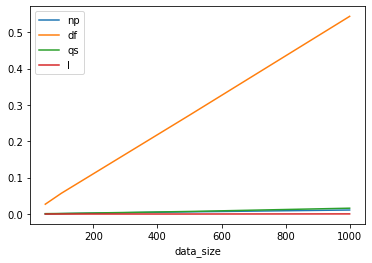

data_size: 1000
	 np 	 0.011 s	 1.0%
	 df 	 0.544 s	 49.454%
	 qs 	 0.016 s	 1.455%
	 l 	 0.0 s	 0.027%


In [35]:
# append
def append_np(data):
    result = {
        'name': np.array([data[0][0]]),
        'age': np.array([data[0][1]]),
        'job': np.array([data[0][2]]),
        }
    for name, age, job in data[1:]:
        np.append(result['name'], [name])
        np.append(result['age'], [age])
        np.append(result['job'], [job])
    return result

def append_df(data):
    result = pd.DataFrame([data[0]], columns=['name', 'age', 'job'])
    for t in data[1:]:
        df = pd.DataFrame([t], columns=['name', 'age', 'job'])
        result.append(df, ignore_index=True)
    return result

def append_qs(data):
    result = Qfrom_slim()
    for t in data:
        result.append(t)
    return result(out.dict)

def append_l(data):
    result = {
        'name': [],
        'age': [],
        'job': [],
    }
    for name, age, job in data:
        result['name'].append(name)
        result['age'].append(age)
        result['job'].append(job)
    return result

test = {
    'test_name': 'append test',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3] + [5*10, 5*10**2],
    'item_name_list': ['np', 'df', 'qs', 'l'],
    'item_setup_list': [setup.list_items, setup.list_items, setup.list_items, setup.list_items],
    'item_func_list': [append_np, append_df, append_qs, append_l]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

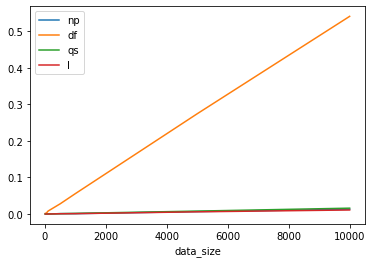

data_size: 10000
	 np 	 0.013 s	 1.0%
	 df 	 0.541 s	 41.617%
	 qs 	 0.016 s	 1.231%
	 l 	 0.011 s	 0.846%


In [36]:
# getitem

def getitem_std(t):
    data, ids = t
    
    for id in ids:
        tuple(col[id] for col in data.values())

def getitem_df(t):
    df, ids = t

    #values = df.values
    for id in ids:
        df.iloc[id]
        #values[id]

def getitem_qs(t):
    q, ids = t
    
    for id in ids:
        q[id]


data_size = 10**5
test = {
    'test_name': 'append test',
    'data_source_func': lambda n: (get_tab_data(data_size), np.random.randint(data_size, size=n)),
    'data_size_list': [10**1, 10**2, 10**3, 10**4] + [5*10, 5*10**2, 5*10**3],
    'item_name_list': ['np', 'df', 'qs', 'l'],
    'item_setup_list': [setup.numpy_tpl, setup.df_tpl, setup.q_slim_tpl, setup.list_tpl],
    'item_func_list': [getitem_std, getitem_df, getitem_std, getitem_std]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

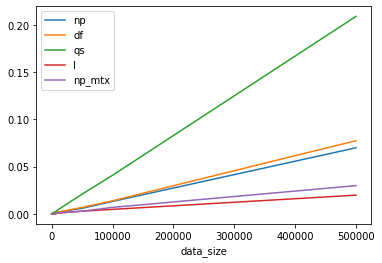

data_size: 500000
	 np 	 0.07 s	 1.0%
	 df 	 0.078 s	 1.108%
	 qs 	 0.209 s	 2.986%
	 l 	 0.02 s	 0.285%
	 np_mtx 	 0.03 s	 0.429%


In [37]:
# iter

def iter_np(data):
    row_count = 0
    #for i in zip(np.nditer(a, flags=["refs_ok"]) for a in data.values()):
    #for i in np.ndindex(len(first(data.values()))):
    for i in np.nditer(list(data.values()), flags=["refs_ok"]):
        #t = tuple(c[i] for c in data.values())
        row_count += 1
    return row_count
def iter_np_mtx(data):
    row_count = 0
    for i in np.nditer(data, flags=["refs_ok"]):
        row_count += 1
    return row_count

def iter_df(df: pd.DataFrame):
    row_count = 0
    for row in df.values:
        row_count += 1
    return row_count

def iter_qs(q: Qfrom_slim):
    row_count = 0
    for row in q:
        row_count += 1
    return row_count

def iter_l(data):
    row_count = 0
    for row in zip(*data.values()):
        row_count += 1
    return row_count


test = {
    'test_name': 'append test',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'qs', 'l', 'np_mtx'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim, setup.list, setup.numpy_mtx],
    'item_func_list': [iter_np, iter_df, iter_qs, iter_l, iter_np_mtx]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

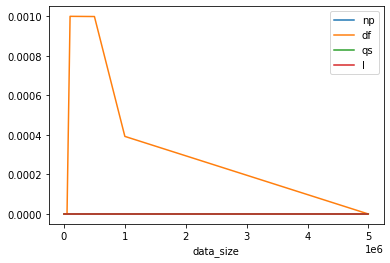

data_size: 5000000
	 np 	 0.0 s	 0%
	 df 	 0.0 s	 0%
	 qs 	 0.0 s	 0%
	 l 	 0.0 s	 0%


In [38]:
# select
cols = 'name'

def select_std(data):
    return {key:value for key, value in data.items() if key in cols}

def select_df(df):
    return df[cols]

def select_qs(q: Qfrom_slim):
    #return q.select(cols)(out.dict)
    return q[cols](out.dict)

test = {
    'test_name': 'select',
    'data_source_func': get_tab_data,
    'data_size_list': [10**3, 10**4, 10**5, 10**6] + [5*10**3, 5*10**4, 5*10**5, 5*10**6],
    'item_name_list': ['np', 'df', 'qs', 'l'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim, setup.list],
    'item_func_list': [select_std, select_df, select_qs, select_std]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

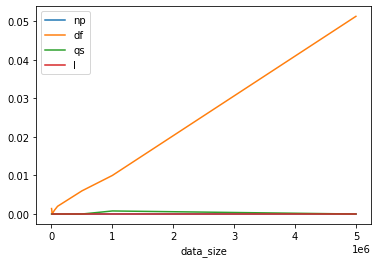

data_size: 5000000
	 np 	 0.0 s	 0%
	 df 	 0.051 s	 0%
	 qs 	 0.0 s	 0%
	 l 	 0.0 s	 0%


In [39]:
# select mult cols
cols = ['name', 'age']

def select_std(data):
    return {key:value for key, value in data.items() if key in cols}

def select_df(df):
    return df[cols]

def select_qs(q: Qfrom_slim):
    #return q.select(cols)(out.dict)
    return q[cols](out.dict)

test = {
    'test_name': 'select mult cols',
    'data_source_func': get_tab_data,
    'data_size_list': [10**3, 10**4, 10**5, 10**6] + [5*10**3, 5*10**4, 5*10**5, 5*10**6],
    'item_name_list': ['np', 'df', 'qs', 'l'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim, setup.list],
    'item_func_list': [select_std, select_df, select_qs, select_std]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

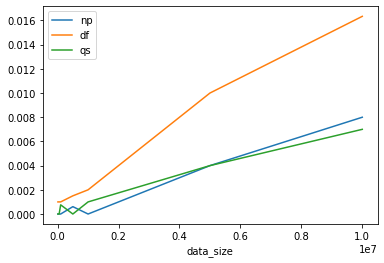

data_size: 10000000
	 np 	 0.008 s	 1.0%
	 df 	 0.016 s	 2.043%
	 qs 	 0.007 s	 0.875%


In [51]:
# map add

def map_add_np(data):
    data['age'] = data['age']+10
    return data

def map_add_df(df: pd.DataFrame):
    #df['age'] = df['age'].map(lambda x: x+10)
    data['age'] = data['age']+10
    return df

#def map_add_l(data):
#    data['age'] = [x+10 for x in data['age']]
#    return data

def map_add_q(q: Qfrom_slim):
    q = q.map(func=lambda age: age+10)
    return q(out.dict)

test = {
    'test_name': 'append test',
    'data_source_func': get_tab_data,
    'data_size_list': [10**4, 10**5, 10**6, 10**7] + [5*10**4, 5*10**5, 5*10**6],
    'item_name_list': ['np', 'df', 'qs'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim],
    'item_func_list': [map_add_np, map_add_np, map_add_q]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

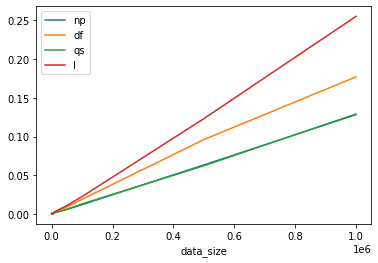

data_size: 1000000
	 np 	 0.128 s	 1.0%
	 df 	 0.177 s	 1.38%
	 qs 	 0.129 s	 1.006%
	 l 	 0.255 s	 1.989%


In [41]:
# map by func
f = lambda x: f'i am {x} years old'

def map_func_np(data):
    map_age = np.frompyfunc(f, 1, 1)
    data['age'] = map_age(data['age'])
    return data

def map_func_df(df: pd.DataFrame):
    df['age'] = df['age'].map(f)
    return df

def map_func_qs(q: Qfrom_slim):
    q = q.map('age', func.vec(f))
    return q(out.dict)

def map_func_l(data):
    data['age'] = [f(x) for x in data['age']]
    return data

test = {
    'test_name': 'append test',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'qs', 'l'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim, setup.list],
    'item_func_list': [map_func_np, map_func_df, map_func_qs, map_func_l]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

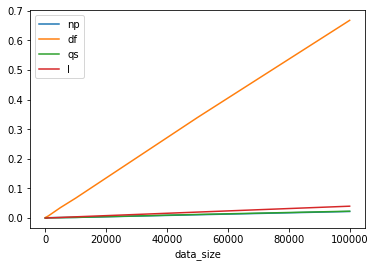

data_size: 100000
	 np 	 0.022 s	 1.0%
	 df 	 0.668 s	 30.356%
	 qs 	 0.023 s	 1.045%
	 l 	 0.04 s	 1.815%


In [42]:
# map by func 2 args
f = lambda x, y: f'My name is {x} and i am {y} years old'

def map_func_np(data):
    map_age = np.frompyfunc(f, 2, 1)
    data['msg'] = map_age(data['name'], data['age'])
    return data

def map_func_df(df: pd.DataFrame):
    df['msg'] = df.apply(lambda x: f(x['name'], x['age']), axis=1)
    return df

def map_func_q(q: Qfrom_slim):
    q = q.map('name, age', func.vec(f), 'msg')
    return q(out.dict)

def map_func_l(data):
    data['msg'] = [f(n,a) for n, a in zip(data['name'], data['age'])]
    return data

test = {
    'test_name': 'append test',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4],
    'item_name_list': ['np', 'df', 'qs', 'l'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim, setup.list],
    'item_func_list': [map_func_np, map_func_df, map_func_q, map_func_l]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

#map_func_q(Qfrom_slim({'name': ['A', 'B', 'C'], 'age': [1, 2, 3]}))

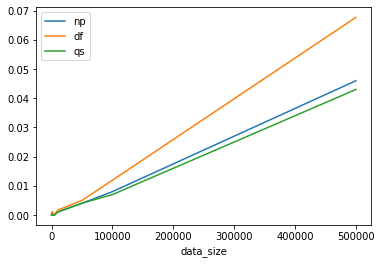

data_size: 500000
	 np 	 0.046 s	 1.0%
	 df 	 0.068 s	 1.472%
	 qs 	 0.043 s	 0.935%


In [43]:
# orderby

def orderby_np(data):
    key_array = data['age']
    sorted_ids = np.argsort(key_array)
    return {key:value[sorted_ids] for key, value in data.items()}

def orderby_df(df):
    return df.sort_values('age')

def orderby_qs(q: Qfrom_slim):
    return q.orderby('age')(out.dict)

#def orderby_l(l):
#    return sorted(l)

test = {
    'test_name': 'append test',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'qs'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim],
    'item_func_list': [orderby_np, orderby_df, orderby_qs]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

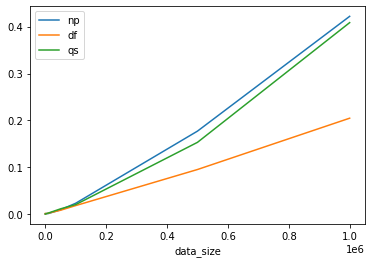

data_size: 1000000
	 np 	 0.422 s	 1.0%
	 df 	 0.205 s	 0.485%
	 qs 	 0.409 s	 0.968%


In [44]:
# orderby multible cols

def orderby_mult_np(data):
    sorted_ids = np.lexsort([data['age'], data['name']])
    return {key:value[sorted_ids] for key, value in data.items()}

def orderby_mult_df(df):
    return df.sort_values(['name', 'age'])

def orderby_mult_qs(q: Qfrom_slim):
    return q.orderby('name, age')(out.dict)

#def orderby_mult_l(l):
#    return sorted(l)

test = {
    'test_name': 'append test',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'qs'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim],
    'item_func_list': [orderby_mult_np, orderby_mult_df, orderby_mult_qs]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

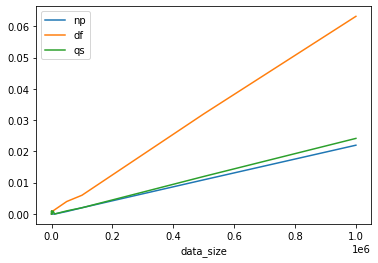

data_size: 1000000
	 np 	 0.022 s	 1.0%
	 df 	 0.063 s	 2.873%
	 qs 	 0.024 s	 1.099%


In [45]:
# where

def where_np(data):
    job_filter = np.where(data['job']=='manager')
    data = {key: value[job_filter] for key, value in data.items()}
    return data

def where_df(df):
    return df[df['job']=='manager']

def where_qs(q: Qfrom_slim):
    return q.where('job', lambda x: x=="manager")(out.dict)

#def where_l(l):
#    return [x for x in l if x['job']=='manager']

test = {
    'test_name': 'where',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'qs'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim],
    'item_func_list': [where_np, where_df, where_qs]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

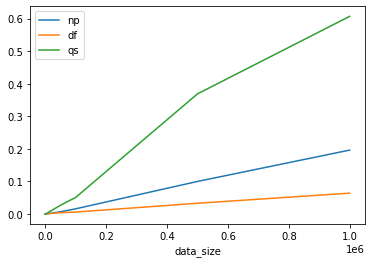

data_size: 1000000
	 np 	 0.196 s	 1.0%
	 df 	 0.064 s	 0.326%
	 qs 	 0.607 s	 3.093%


In [46]:
# groupby
cols = 'job'

def groupby_np(data):
    sorted_ids = np.argsort(data[cols])
    sorted_key_array = data[cols][sorted_ids]
    unique_keys, unique_key_ids = np.unique(sorted_key_array, return_index=True)
    id_groups = np.split(sorted_ids, unique_key_ids[1:])
    group_dict = {
        'key': unique_keys,
        'group': np.array([{key:col[ids] for key, col in data.items()} for ids in id_groups])
        }

    return group_dict


def groupby_df(df: pd.DataFrame):
    return df.groupby(cols).groups

def groupby_qs(q: Qfrom_slim):
    return q.groupby(cols)(out.dict)

#def group_l(l):
#    return list(itertools.groupby(l, key=lambda x: x['job']))

test = {
    'test_name': 'groupby',
    'data_source_func': get_tab_data,
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'qs'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim],
    'item_func_list': [groupby_np, groupby_df, groupby_qs]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

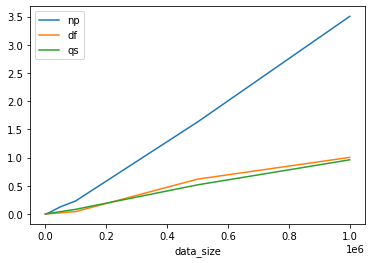

data_size: 1000000
	 np 	 3.506 s	 1.0%
	 df 	 1.005 s	 0.287%
	 qs 	 0.962 s	 0.274%


In [52]:
# groupby
cols = ['job', 'name']

def group_by_dict(key_iter: Iterable):
    group_ids_dict = {}
    for i, key in enumerate(key_iter):
        if key not in group_ids_dict:
            #group_ids_dict[key] = []
            group_ids_dict[key] = []
        group_ids_dict[key].append(i)
    
    return group_ids_dict

def groupby_np(data):
    #start_time = time.time()
    
    sorted_ids = np.lexsort([data[c] for c in cols[::-1]])
    
    #print(f'sort: {time.time()-start_time}')
    #start_time = time.time()
    
    sorted_key_array = array_tuple_to_tuple_array([c for k, c in data.items() if k in cols])
    
    #print(f'key array: {time.time()-start_time}')
    #start_time = time.time()
    
    unique_keys, unique_key_ids = np.unique(sorted_key_array, return_index=True)
    #group_by_dict(sorted_key_array)

    #print(f'unique: {time.time()-start_time}')
    #start_time = time.time()
    
    id_groups = np.split(sorted_ids, unique_key_ids[1:])
    
    #print(f'split: {time.time()-start_time}')
    #start_time = time.time()
    
    group_dict = {
        'key': unique_keys,
        'group': np.array([{key:col[ids] for key, col in data.items()} for ids in id_groups])
        }
    
    #print(f'to dict: {time.time()-start_time}')
    
    return group_dict


def groupby_df(df: pd.DataFrame):
    return df.groupby(cols).groups

def groupby_qs(q: Qfrom_slim):
    return q.groupby(cols)(out.dict)

test = {
    'test_name': 'groupby',
    'data_source_func': get_tab_data,
    'data_size_list': [10**3, 10**4, 10**5, 10**6] + [5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'qs'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim],
    'item_func_list': [groupby_np, groupby_df, groupby_qs]
    }
q_results = run_test(test)(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

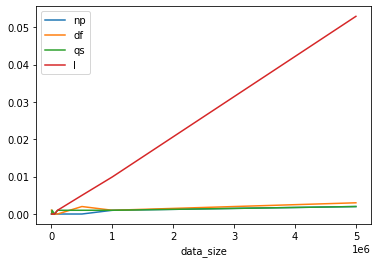

data_size: 5000000
	 np 	 0.002 s	 1.0%
	 df 	 0.003 s	 1.5%
	 qs 	 0.002 s	 1.001%
	 l 	 0.053 s	 26.46%


In [49]:
# agg

def agg_np(data):
    return np.max(data['age'])

def agg_df(df: pd.DataFrame):
    return df['age'].agg('max')

def agg_qs(q: Qfrom_slim):
    return q['age'].agg(agg.max)

def agg_l(data):
    return max(data['age'])

test = {
    'test_name': 'agg',
    'data_source_func': get_tab_data,
    'data_size_list': [10**3, 10**4, 10**5, 10**6] + [5*10**3, 5*10**4, 5*10**5, 5*10**6],
    'item_name_list': ['np', 'df', 'qs', 'l'],
    'item_setup_list': [setup.numpy, setup.df, setup.q_slim, setup.list],
    'item_func_list': [agg_np, agg_df, agg_qs, agg_l]
    }
q_results = run_test(test)
q_results = q_results(get_data_size_tab)
q_results(plot.plot, x='data_size')
q_results(print_max_stats)

In [48]:
n = 5*10**5
data = get_tab_data(n)
np_data = setup.numpy(data)
np_g = groupby_np(np_data)

In [50]:
n = 4
data = get_tab_data(n)
print(data)
np_data = setup.numpy(data)
df_data = setup.df(data)
qs_data = setup.q_slim(data)
np_g = groupby_np(np_data)
df_g = groupby_df(df_data)
qs_g = groupby_qs(qs_data)
print(f'{np_g=}')
print(f'{df_g=}')
print(f'{qs_g=}')

{'name': array(['Ann', 'Jack', 'Max', 'Ann'], dtype='<U8'), 'age': array([52,  0, 69, 35]), 'job': array(['freelancer', 'manager', 'freelancer', 'manager'], dtype='<U10')}
np_g={'key': array([('Ann', 'freelancer'), ('Ann', 'manager'), ('Jack', 'manager'),
       ('Max', 'freelancer')], dtype=object), 'group': array([{'name': array(['Ann', 'Max', 'Ann'], dtype='<U8'), 'age': array([52, 69, 35]), 'job': array(['freelancer', 'freelancer', 'manager'], dtype='<U10')},
       {'name': array([], dtype='<U8'), 'age': array([], dtype=int32), 'job': array([], dtype='<U10')},
       {'name': array(['Max'], dtype='<U8'), 'age': array([69]), 'job': array(['freelancer'], dtype='<U10')},
       {'name': array(['Ann', 'Jack'], dtype='<U8'), 'age': array([35,  0]), 'job': array(['manager', 'manager'], dtype='<U10')}],
      dtype=object)}
df_g={('freelancer', 'Ann'): [0], ('freelancer', 'Max'): [2], ('manager', 'Ann'): [3], ('manager', 'Jack'): [1]}
qs_g={'key': array([('freelancer', 'Ann'), ('manager'